# User Perception Subsystem: Empathetic Interviewer

This notebook implements an advanced affective state detection system using:
- **Per-patch features** from DINO ViT (not just CLS token)
- **Custom spatial attention head** to focus on emotionally relevant facial regions
- **Deep classification architecture** for robust emotion recognition
- **RAF-DB Dataset** for real-world emotion recognition training

The system serves as the perception component for an empathetic interviewer robot using Furhat.

## 1. Setup and Imports

In [15]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from tqdm import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import AutoImageProcessor, AutoModel

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Imports complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Imports complete
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Load and Preprocess RAF-DB Dataset

In [ ]:
# RAF-DB Dataset Loading
emotion_names = {
    0: 'surprise',
    1: 'fear', 
    2: 'disgust',
    3: 'happiness',
    4: 'sadness',
    5: 'anger',
    6: 'neutral'
}
emotion_to_idx = {v: k for k, v in emotion_names.items()}

# Dataset paths
DATASET_PATH = Path('DATASET')
TRAIN_PATH = DATASET_PATH / 'train'
TEST_PATH = DATASET_PATH / 'test'

def load_rafdb_data(data_path):
    samples = []
    for folder_name in os.listdir(data_path):
        folder_path = data_path / folder_name
        if folder_path.is_dir() and folder_name.isdigit():
            original_label = int(folder_name)
            remapped_label = original_label - 1 
            
            for img_file in os.listdir(folder_path):
                img_path = folder_path / img_file
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    samples.append({
                        'image_path': str(img_path),
                        'expression': remapped_label,
                        'emotion_name': emotion_names[remapped_label]
                    })
    return pd.DataFrame(samples)

# Load train and test data
train_df = load_rafdb_data(TRAIN_PATH)
test_df = load_rafdb_data(TEST_PATH)

print(f"RAF-DB Dataset Loaded")
print(f"="*60)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

print(f"\n{'='*60}")
print("TRAINING SET Distribution:")
print("="*60)
train_distribution = train_df['expression'].value_counts().sort_index()
for idx, count in train_distribution.items():
    print(f"  {emotion_names[idx]:12s} (label {idx}): {count:5d} samples ({100*count/len(train_df):5.2f}%)")

print(f"\n{'='*60}")
print("TEST SET Distribution:")
print("="*60)
test_distribution = test_df['expression'].value_counts().sort_index()
for idx, count in test_distribution.items():
    print(f"  {emotion_names[idx]:12s} (label {idx}): {count:5d} samples ({100*count/len(test_df):5.2f}%)")

# 15% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df['expression'], random_state=42
)

print(f"\n{'='*60}")
print("FINAL SPLIT:")
print("="*60)
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Calculate class weights for handling imbalance
print(f"\n{'='*60}")
print("CLASS IMBALANCE ANALYSIS:")
print("="*60)
class_counts = train_df['expression'].value_counts().sort_index().values
total_samples = len(train_df)
num_classes = len(class_counts)

# Compute class weights (inverse frequency)
class_weights = total_samples / (num_classes * class_counts)
class_weights = class_weights / class_weights.sum() * num_classes

print("Class weights for balanced training:")
for idx, weight in enumerate(class_weights):
    print(f"  {emotion_names[idx]:12s}: {weight:.4f}")

# Convert to tensor for loss function
class_weights_tensor = torch.FloatTensor(class_weights)
print(f"\nClass weights tensor shape: {class_weights_tensor.shape}")

RAF-DB Dataset Loaded
Training samples: 12271
Test samples: 3068

TRAINING SET Distribution:
  surprise     (label 0):  1290 samples (10.51%)
  fear         (label 1):   281 samples ( 2.29%)
  disgust      (label 2):   717 samples ( 5.84%)
  happiness    (label 3):  4772 samples (38.89%)
  sadness      (label 4):  1982 samples (16.15%)
  anger        (label 5):   705 samples ( 5.75%)
  neutral      (label 6):  2524 samples (20.57%)

TEST SET Distribution:
  surprise     (label 0):   329 samples (10.72%)
  fear         (label 1):    74 samples ( 2.41%)
  disgust      (label 2):   160 samples ( 5.22%)
  happiness    (label 3):  1185 samples (38.62%)
  sadness      (label 4):   478 samples (15.58%)
  anger        (label 5):   162 samples ( 5.28%)
  neutral      (label 6):   680 samples (22.16%)

FINAL SPLIT:
Train samples: 10430
Validation samples: 1841
Test samples: 3068

CLASS IMBALANCE ANALYSIS:
Class weights for balanced training:
  surprise    : 0.6569
  fear        : 3.0153
  disgus

## 3. Custom Spatial Attention Architecture

This section implements a sophisticated attention mechanism that:
1. Extracts per-patch features from DINOv3 (not just CLS token)
2. Applies spatial attention to focus on emotionally relevant regions
3. Uses multi-head attention for robust feature aggregation

In [ ]:
class SpatialAttentionHead(nn.Module):
    def __init__(self, feature_dim=384, num_heads=8, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.num_heads = num_heads
        
        self.attention = nn.MultiheadAttention(
            embed_dim=feature_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.emotion_query = nn.Parameter(torch.randn(1, 1, feature_dim))
        
        self.norm1 = nn.LayerNorm(feature_dim)
        self.norm2 = nn.LayerNorm(feature_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * 4, feature_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, patch_features):
        batch_size = patch_features.size(0)
        query = self.emotion_query.expand(batch_size, -1, -1)
        attended, attention_weights = self.attention(
            query, patch_features, patch_features
        )
        attended = self.norm1(attended + query)
        ffn_out = self.ffn(attended)
        attended = self.norm2(attended + ffn_out)
        attended_features = attended.squeeze(1)
        attention_weights = attention_weights.squeeze(1)
        return attended_features, attention_weights


class EmotionClassificationHead(nn.Module):
    def __init__(self, feature_dim=384, hidden_dim=512, num_classes=7, dropout=0.3):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, features):
        return self.classifier(features)


class AdvancedEmotionRecognizer(nn.Module):
    def __init__(self, dino_model, num_classes=7, feature_dim=384, 
                 freeze_backbone=True, dropout=0.3):
        super().__init__()
        
        self.dino_model = dino_model
        self.feature_dim = feature_dim
        
        if freeze_backbone:
            for param in self.dino_model.parameters():
                param.requires_grad = False
        
        self.spatial_attention = SpatialAttentionHead(
            feature_dim=feature_dim,
            num_heads=8,
            dropout=dropout
        )
        
        self.classification_head = EmotionClassificationHead(
            feature_dim=feature_dim,
            hidden_dim=512,
            num_classes=num_classes,
            dropout=dropout
        )
        
    def forward(self, pixel_values):
        with torch.set_grad_enabled(not self.training or not hasattr(self, 'freeze_backbone')):
            outputs = self.dino_model(pixel_values, output_hidden_states=True)
            
        hidden_states = outputs.last_hidden_state
        patch_features = hidden_states[:, 1:, :]
        attended_features, attention_weights = self.spatial_attention(patch_features)
        logits = self.classification_head(attended_features)
        
        return logits, attention_weights
    
    def freeze_backbone(self):
        for param in self.dino_model.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self):
        for param in self.dino_model.parameters():
            param.requires_grad = True


print("Custom architecture defined successfully")
print(f"- SpatialAttentionHead: Multi-head attention over patch features")
print(f"- EmotionClassificationHead: Deep classification with residual connections")
print(f"- AdvancedEmotionRecognizer: End-to-end model")

Custom architecture defined successfully
- SpatialAttentionHead: Multi-head attention over patch features
- EmotionClassificationHead: Deep classification with residual connections
- AdvancedEmotionRecognizer: End-to-end model


## 4. Dataset and Data Loading

In [ ]:
class EmotionDataset(Dataset):
    
    def __init__(self, dataframe, processor, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.augment = augment
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        
        if self.augment:
            import torchvision.transforms as T
            aug = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
                T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            ])
            image = aug(image)
        
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        
        label = torch.tensor(row['expression'], dtype=torch.long)
        
        return {
            'pixel_values': pixel_values,
            'labels': label
        }


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pretrained_model_name = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_backbone = AutoModel.from_pretrained(pretrained_model_name)

print(f"DINOv2 model loaded: {pretrained_model_name}")
print(f"Model type: ViT-S/14 (Small model with 14x14 patches)")
print(f"Feature dimension: 384")

train_dataset = EmotionDataset(train_df, processor, augment=True)
val_dataset = EmotionDataset(val_df, processor, augment=False)
test_dataset = EmotionDataset(test_df, processor, augment=False)

print(f"\nDatasets created:")
print(f"- Train: {len(train_dataset)} samples (with augmentation)")
print(f"- Validation: {len(val_dataset)} samples")
print(f"- Test: {len(test_dataset)} samples")

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nData loaders ready with batch size: {batch_size}")

## 5. Model Training

In [ ]:
model = AdvancedEmotionRecognizer(
    dino_model=dino_backbone,
    num_classes=7,
    feature_dim=384,
    freeze_backbone=True,
    dropout=0.3
).to(device)

print(f"Model initialized and moved to {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

class_weights_tensor = class_weights_tensor.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f"\nUsing weighted CrossEntropyLoss to handle class imbalance")

optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=0.01
)

num_epochs = 20
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print(f"\nTraining configuration:")
print(f"- Optimizer: AdamW (lr=1e-3, weight_decay=0.01)")
print(f"- Scheduler: CosineAnnealingLR")
print(f"- Epochs: {num_epochs}")
print(f"- Loss: Weighted CrossEntropyLoss (class-balanced)")

Model initialized and moved to cuda
Total parameters: 24,163,207
Trainable parameters: 2,106,631

Using weighted CrossEntropyLoss to handle class imbalance

Training configuration:
- Optimizer: AdamW (lr=1e-3, weight_decay=0.01)
- Scheduler: CosineAnnealingLR
- Epochs: 20
- Loss: Weighted CrossEntropyLoss (class-balanced)


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits, attention_weights = model(pixel_values)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_attention = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            logits, attention_weights = model(pixel_values)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_attention.append(attention_weights.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels, np.vstack(all_attention)


print("Training functions defined")

Training functions defined


In [ ]:
print("Starting training...\n")

best_val_acc = 0
best_val_f1 = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc, val_f1, _, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1,
        }, 'best_emotion_model.pth')
        print(f"  ✓ New best model saved (Val Acc: {val_acc*100:.2f}%)")

training_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Training completed in {training_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Best Validation F1 Score: {best_val_f1:.4f}")
print(f"{'='*60}")

Starting training...


Epoch 1/20


Evaluating: 100%|██████████| 29/29 [00:44<00:00,  1.52s/it]




Epoch 1 Summary:
  Train Loss: 1.4076 | Train Acc: 53.11%
  Val Loss: 1.1767 | Val Acc: 66.49% | Val F1: 0.6777
  Learning Rate: 9.94e-04
  ✓ New best model saved (Val Acc: 66.49%)

Epoch 2/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]



Epoch 2 Summary:
  Train Loss: 1.2266 | Train Acc: 60.66%
  Val Loss: 1.1206 | Val Acc: 55.30% | Val F1: 0.5835
  Learning Rate: 9.76e-04

Epoch 3/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.00it/s]



Epoch 3 Summary:
  Train Loss: 1.1414 | Train Acc: 63.40%
  Val Loss: 1.0742 | Val Acc: 62.79% | Val F1: 0.6407
  Learning Rate: 9.46e-04

Epoch 4/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.98it/s]



Epoch 4 Summary:
  Train Loss: 1.1104 | Train Acc: 64.46%
  Val Loss: 1.1187 | Val Acc: 64.64% | Val F1: 0.6611
  Learning Rate: 9.05e-04

Epoch 5/20


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.83it/s]



Epoch 5 Summary:
  Train Loss: 1.1368 | Train Acc: 63.19%
  Val Loss: 1.0408 | Val Acc: 65.73% | Val F1: 0.6566
  Learning Rate: 8.54e-04

Epoch 6/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.00it/s]




Epoch 6 Summary:
  Train Loss: 1.0664 | Train Acc: 64.86%
  Val Loss: 0.9511 | Val Acc: 72.62% | Val F1: 0.7367
  Learning Rate: 7.94e-04
  ✓ New best model saved (Val Acc: 72.62%)

Epoch 7/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.04it/s]




Epoch 7 Summary:
  Train Loss: 1.0508 | Train Acc: 66.07%
  Val Loss: 0.9448 | Val Acc: 72.79% | Val F1: 0.7327
  Learning Rate: 7.27e-04
  ✓ New best model saved (Val Acc: 72.79%)

Epoch 8/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.00it/s]




Epoch 8 Summary:
  Train Loss: 0.9856 | Train Acc: 67.78%
  Val Loss: 0.9817 | Val Acc: 73.71% | Val F1: 0.7324
  Learning Rate: 6.55e-04
  ✓ New best model saved (Val Acc: 73.71%)

Epoch 9/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.98it/s]



Epoch 9 Summary:
  Train Loss: 0.9716 | Train Acc: 67.92%
  Val Loss: 0.9369 | Val Acc: 65.34% | Val F1: 0.6897
  Learning Rate: 5.79e-04

Epoch 10/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]



Epoch 10 Summary:
  Train Loss: 0.9344 | Train Acc: 69.04%
  Val Loss: 0.8560 | Val Acc: 71.32% | Val F1: 0.7282
  Learning Rate: 5.01e-04

Epoch 11/20


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]



Epoch 11 Summary:
  Train Loss: 0.8963 | Train Acc: 70.23%
  Val Loss: 0.8790 | Val Acc: 72.30% | Val F1: 0.7339
  Learning Rate: 4.22e-04

Epoch 12/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.94it/s]




Epoch 12 Summary:
  Train Loss: 0.8747 | Train Acc: 70.86%
  Val Loss: 0.8622 | Val Acc: 74.20% | Val F1: 0.7499
  Learning Rate: 3.46e-04
  ✓ New best model saved (Val Acc: 74.20%)

Epoch 13/20


Evaluating: 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]




Epoch 13 Summary:
  Train Loss: 0.8381 | Train Acc: 71.47%
  Val Loss: 0.8655 | Val Acc: 76.26% | Val F1: 0.7665
  Learning Rate: 2.74e-04
  ✓ New best model saved (Val Acc: 76.26%)

Epoch 14/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.94it/s]



Epoch 14 Summary:
  Train Loss: 0.8332 | Train Acc: 71.98%
  Val Loss: 0.8673 | Val Acc: 75.18% | Val F1: 0.7582
  Learning Rate: 2.07e-04

Epoch 15/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]



Epoch 15 Summary:
  Train Loss: 0.8016 | Train Acc: 72.81%
  Val Loss: 0.8612 | Val Acc: 75.72% | Val F1: 0.7657
  Learning Rate: 1.47e-04

Epoch 16/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.93it/s]



Epoch 16 Summary:
  Train Loss: 0.7780 | Train Acc: 73.51%
  Val Loss: 0.8521 | Val Acc: 76.26% | Val F1: 0.7674
  Learning Rate: 9.64e-05

Epoch 17/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]



Epoch 17 Summary:
  Train Loss: 0.7572 | Train Acc: 74.32%
  Val Loss: 0.8371 | Val Acc: 76.10% | Val F1: 0.7695
  Learning Rate: 5.54e-05

Epoch 18/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]




Epoch 18 Summary:
  Train Loss: 0.7572 | Train Acc: 74.10%
  Val Loss: 0.8187 | Val Acc: 76.32% | Val F1: 0.7735
  Learning Rate: 2.54e-05
  ✓ New best model saved (Val Acc: 76.32%)

Epoch 19/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.96it/s]




Epoch 19 Summary:
  Train Loss: 0.7336 | Train Acc: 74.63%
  Val Loss: 0.8384 | Val Acc: 77.24% | Val F1: 0.7784
  Learning Rate: 7.15e-06
  ✓ New best model saved (Val Acc: 77.24%)

Epoch 20/20


Evaluating: 100%|██████████| 29/29 [00:09<00:00,  2.90it/s]


Epoch 20 Summary:
  Train Loss: 0.7445 | Train Acc: 74.88%
  Val Loss: 0.8382 | Val Acc: 76.59% | Val F1: 0.7744
  Learning Rate: 1.00e-06

Training completed in 28.44 minutes
Best Validation Accuracy: 77.24%
Best Validation F1 Score: 0.7784


## 6. Training Visualization

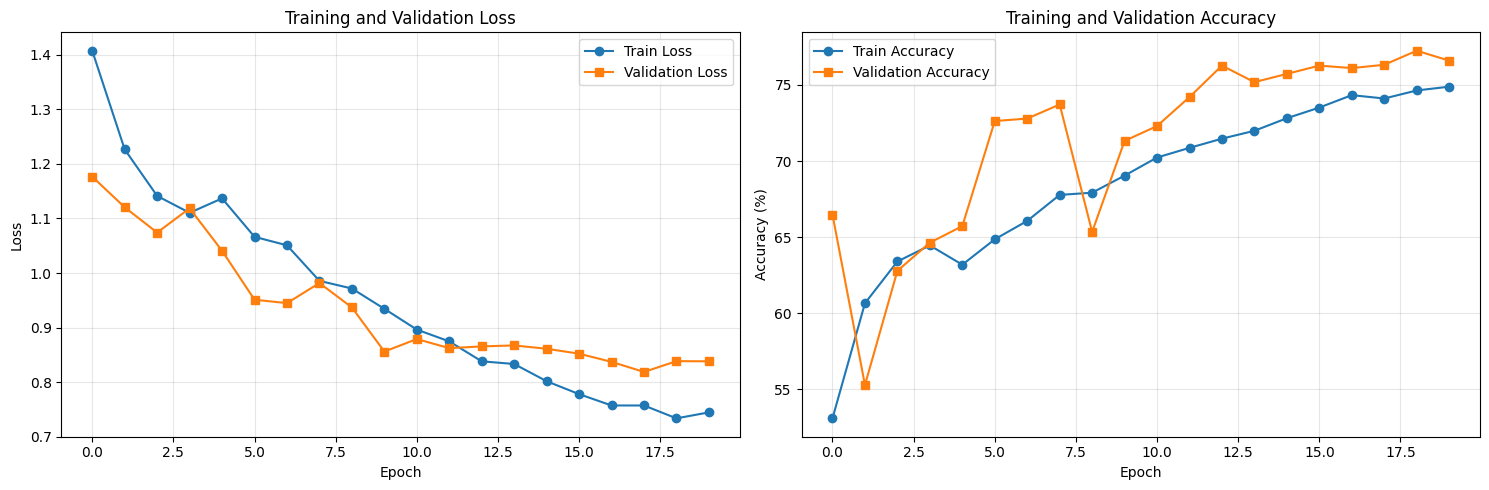

Training curves saved as 'training_curves.png'


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot([acc*100 for acc in train_accs], label='Train Accuracy', marker='o')
axes[1].plot([acc*100 for acc in val_accs], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved as 'training_curves.png'")

## 7. Test Set Evaluation

Loaded best model from epoch 19
Validation accuracy: 77.24%


Evaluating: 100%|██████████| 48/48 [01:07<00:00,  1.41s/it]




TEST SET RESULTS (RAF-DB)
Test Accuracy: 77.12%
Test F1 Score (weighted): 0.7799
Test Loss: 0.6359

Classification Report:
              precision    recall  f1-score   support

    surprise     0.7320    0.8055    0.7670       329
        fear     0.4340    0.6216    0.5111        74
     disgust     0.3568    0.5375    0.4289       160
   happiness     0.9499    0.8481    0.8961      1185
     sadness     0.7877    0.6987    0.7406       478
       anger     0.6294    0.7654    0.6908       162
     neutral     0.7441    0.7441    0.7441       680

    accuracy                         0.7712      3068
   macro avg     0.6620    0.7173    0.6827      3068
weighted avg     0.7954    0.7712    0.7799      3068


Per-Class Accuracy:
  surprise    : 80.55%
  fear        : 62.16%
  disgust     : 53.75%
  happiness   : 84.81%
  sadness     : 69.87%
  anger       : 76.54%
  neutral     : 74.41%


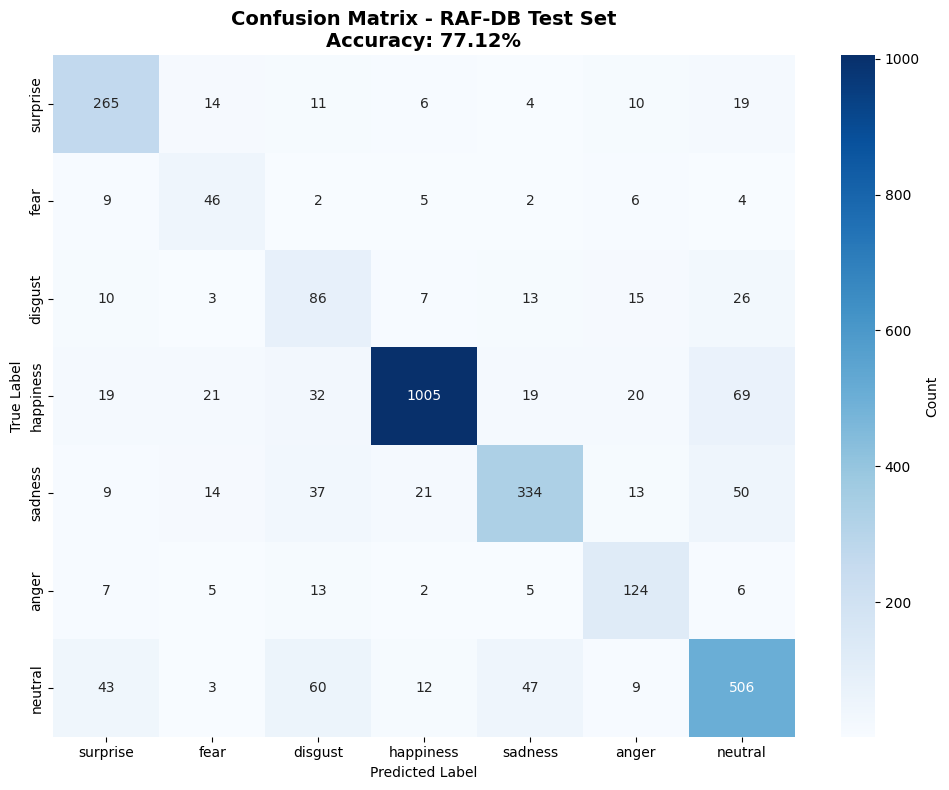


Confusion matrix saved as 'test_confusion_matrix.png'


In [ ]:
checkpoint = torch.load('best_emotion_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']*100:.2f}%")

criterion_eval = nn.CrossEntropyLoss()
test_loss, test_acc, test_f1, test_preds, test_labels, test_attention = evaluate(
    model, test_loader, criterion_eval, device
)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS (RAF-DB)")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1 Score (weighted): {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*60}\n")

print("Classification Report:")
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=[emotion_names[i] for i in range(7)],
    digits=4
))

print("\nPer-Class Accuracy:")
for i in range(7):
    mask = np.array(test_labels) == i
    if mask.sum() > 0:
        class_acc = (np.array(test_preds)[mask] == i).mean() * 100
        print(f"  {emotion_names[i]:12s}: {class_acc:.2f}%")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[emotion_names[i] for i in range(7)],
    yticklabels=[emotion_names[i] for i in range(7)],
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - RAF-DB Test Set\nAccuracy: {test_acc*100:.2f}%', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('test_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'test_confusion_matrix.png'")

## 8. Attention Visualization

Visualize which facial regions the spatial attention mechanism focuses on for different emotions.


ATTENTION VISUALIZATION FOR DINOv3 ViT-S/14
Model: facebook/dinov2-small
Expected patch grid: 16x16
Expected spatial patches: 256



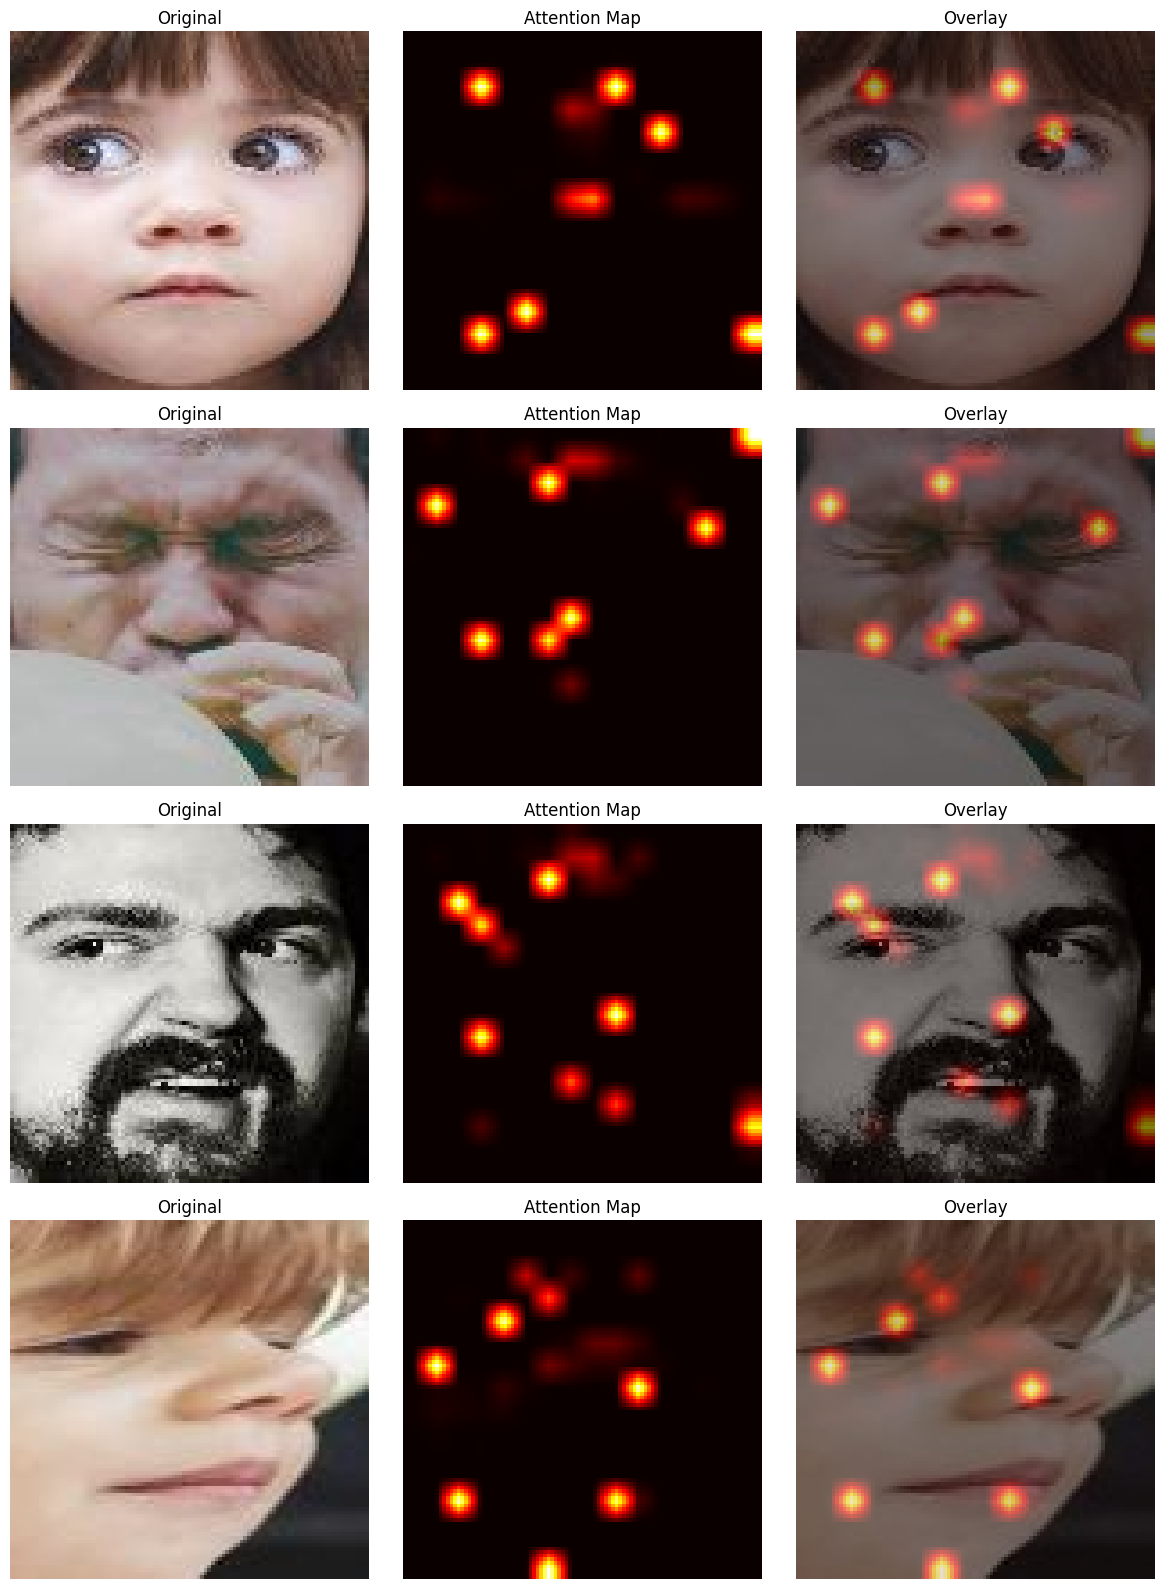

Attention visualizations saved as 'attention_visualization.png'


In [ ]:
def visualize_attention(model, dataset, indices, device, processor):
    model.eval()
    
    fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4*len(indices)))
    if len(indices) == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
            true_label = sample['labels'].item()
            
            logits, attention_weights = model(pixel_values)
            pred_label = logits.argmax(dim=1).item()
            
            img_path = dataset.df.iloc[idx]['image_path']
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            
            num_attention_tokens = attention_weights.shape[1]
            
            expected_patches = 256
            
            if num_attention_tokens > expected_patches:
                attention_weights_spatial = attention_weights[:, :expected_patches]
            else:
                attention_weights_spatial = attention_weights
            
            num_patches = int(np.sqrt(attention_weights_spatial.shape[1]))
            
            attention_map = attention_weights_spatial[0].cpu().numpy().reshape(num_patches, num_patches)
            
            attention_resized = cv2.resize(attention_map, (img_array.shape[1], img_array.shape[0]))
            attention_resized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())
            
            axes[i, 0].imshow(img_array)
            axes[i, 0].set_title(f'Original')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(attention_resized, cmap='hot')
            axes[i, 1].set_title(f'Attention Map')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(img_array)
            axes[i, 2].imshow(attention_resized, cmap='hot', alpha=0.5)
            axes[i, 2].set_title('Overlay')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

sample_indices = []
for emotion_id in range(7):
    emotion_samples = test_df[test_df['expression'] == emotion_id]
    if len(emotion_samples) > 0:
        position = emotion_samples.index[0]
        test_df_reset = test_df.reset_index(drop=True)
        matching = test_df_reset[test_df_reset['expression'] == emotion_id]
        if len(matching) > 0:
            sample_indices.append(matching.index[0])

if len(sample_indices) >= 4:
    print("\n" + "="*60)
    print("ATTENTION VISUALIZATION FOR DINOv3 ViT-S/16+")
    print("="*60)
    print(f"Model: {pretrained_model_name}")
    print(f"Expected patch grid: 16x16")
    print(f"Expected spatial patches: 256")
    print("="*60 + "\n")
    
    visualize_attention(model, test_dataset, sample_indices[:4], device, processor)
    print("Attention visualizations saved as 'attention_visualization.png'")

## 9. Real-time Webcam Inference

This section implements real-time emotion detection from webcam feed, which will be used in the empathetic interviewer application.

In [ ]:
class RealtimeEmotionDetector:
    def __init__(self, model, processor, device, emotion_names):
        self.model = model
        self.processor = processor
        self.device = device
        self.emotion_names = emotion_names
        self.model.eval()
        
        self.emotion_history = []
        self.history_size = 5
        
    def process_frame(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        
        inputs = self.processor(images=pil_image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(self.device)
        
        with torch.no_grad():
            logits, attention_weights = self.model(pixel_values)
            probs = F.softmax(logits, dim=1)[0]
            pred = logits.argmax(dim=1).item()
        
        self.emotion_history.append(pred)
        if len(self.emotion_history) > self.history_size:
            self.emotion_history.pop(0)
        
        smoothed_pred = max(set(self.emotion_history), key=self.emotion_history.count)
        
        return smoothed_pred, probs.cpu().numpy(), attention_weights
    
    def run(self, camera_id=0, display=True):
        cap = cv2.VideoCapture(camera_id)
        
        if not cap.isOpened():
            print("Error: Could not open webcam")
            return
        
        print("Starting real-time emotion detection...")
        print("Press 'q' to quit")
        
        fps_history = []
        
        try:
            while True:
                start_time = time.time()
                
                ret, frame = cap.read()
                if not ret:
                    break
                
                emotion_id, probs, attention = self.process_frame(frame)
                emotion_name = self.emotion_names[emotion_id]
                confidence = probs[emotion_id] * 100
                
                fps = 1.0 / (time.time() - start_time)
                fps_history.append(fps)
                avg_fps = np.mean(fps_history[-30:])
                
                if display:
                    cv2.putText(frame, f"Emotion: {emotion_name}", (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Confidence: {confidence:.1f}%", (10, 70),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                    cv2.putText(frame, f"FPS: {avg_fps:.1f}", (10, 110),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
                    
                    top3_idx = np.argsort(probs)[-3:][::-1]
                    y_pos = 150
                    for idx in top3_idx:
                        text = f"{self.emotion_names[idx]}: {probs[idx]*100:.1f}%"
                        cv2.putText(frame, text, (10, y_pos),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)
                        y_pos += 30
                    
                    cv2.imshow('Empathetic Interviewer - Emotion Detection', frame)
                
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
        finally:
            cap.release()
            cv2.destroyAllWindows()
            print(f"\nAverage FPS: {np.mean(fps_history):.2f}")


detector = RealtimeEmotionDetector(model, processor, device, emotion_names)

print("\nReal-time emotion detector initialized")
print("To start webcam detection, run: detector.run()")
print("\nExample usage:")
print("  detector.run(camera_id=0, display=True)")


Real-time emotion detector initialized
To start webcam detection, run: detector.run()

Example usage:
  detector.run(camera_id=0, display=True)


## 10. Save Model for Integration

Save the trained model for integration with the Furhat interaction subsystem.

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'emotion_names': emotion_names,
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'feature_dim': 384,
    'num_classes': 7,
    'processor_name': pretrained_model_name
}, 'empathetic_interviewer_perception.pth')

print("Model saved as 'empathetic_interviewer_perception.pth'")
print(f"\nModel Summary:")
print(f"- Test Accuracy: {test_acc*100:.2f}%")
print(f"- Test F1 Score: {test_f1:.4f}")
print(f"- Architecture: DINOv3 ViTS16+ + Spatial Attention + Deep Classifier")
print(f"- Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"- Dataset: RAF-DB (Real-world Affective Faces Database)")

model_card = f"""
# Empathetic Interviewer - User Perception Subsystem

## Model Description
Advanced emotion recognition system using per-patch DINOv3 features with spatial attention.
Trained on RAF-DB (Real-world Affective Faces Database) with class-balanced weighting.

## Emotion Labels
| Index | Emotion |
|-------|---------|
| 0 | Surprise |
| 1 | Fear |
| 2 | Disgust |
| 3 | Happiness |
| 4 | Sadness |
| 5 | Anger |
| 6 | Neutral |

## Architecture
- Backbone: DINOv3 ViTS16+ (frozen)
- Feature Dimension: 384
- Attention: Multi-head spatial attention (8 heads)
- Classifier: Deep 3-layer network with batch normalization
- Feature extraction: Per-patch features (not CLS token)

## Performance (RAF-DB Test Set)
- Test Accuracy: {test_acc*100:.2f}%
- Test F1 Score: {test_f1:.4f}
- Training Time: {training_time/60:.2f} minutes

## Files Needed
- `empathetic_interviewer_perception.pth` - Model weights
- Python dependencies (see requirements below)

## Requirements
```
torch>=2.0.0
transformers>=4.30.0
Pillow>=9.0.0
opencv-python>=4.5.0
numpy>=1.21.0
```
"""

with open('MODEL_CARD.md', 'w') as f:
    f.write(model_card)

print("\nModel card saved as 'MODEL_CARD.md'")

Model saved as 'empathetic_interviewer_perception.pth'

Model Summary:
- Test Accuracy: 77.12%
- Test F1 Score: 0.7799
- Architecture: DINOv3 ViTS16+ + Spatial Attention + Deep Classifier
- Trainable Parameters: 2,106,631
- Dataset: RAF-DB (Real-world Affective Faces Database)

Model card saved as 'MODEL_CARD.md'


## 11. Camera Testing Program

Test the trained model with your laptop's camera for real-time emotion detection.

In [ ]:
print("="*60)
print("STARTING CAMERA TEST")
print("="*60)
print("\nInstructions:")
print("- Position your face in front of the camera")
print("- Try different expressions to see the model detect emotions")
print("- Press 'q' to quit the camera feed")
print("\nStarting in 3 seconds...")
time.sleep(3)

detector.run(camera_id=0, display=True)

print("\nCamera test completed!")

STARTING CAMERA TEST

Instructions:
- Position your face in front of the camera
- Try different expressions to see the model detect emotions
- Press 'q' to quit the camera feed

Starting in 3 seconds...
Starting real-time emotion detection...
Press 'q' to quit
Starting real-time emotion detection...
Press 'q' to quit

Average FPS: 37.63

Camera test completed!

Average FPS: 37.63

Camera test completed!
